In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, minmax_scale
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from copy import deepcopy
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

*Import Data*

In [20]:
train_df = pd.read_csv('data/train.csv').drop(columns='ID_code')
test_df = pd.read_csv('data/test.csv').drop(columns='ID_code')

## EDA

*Correlation Heatmap*

<Axes: >

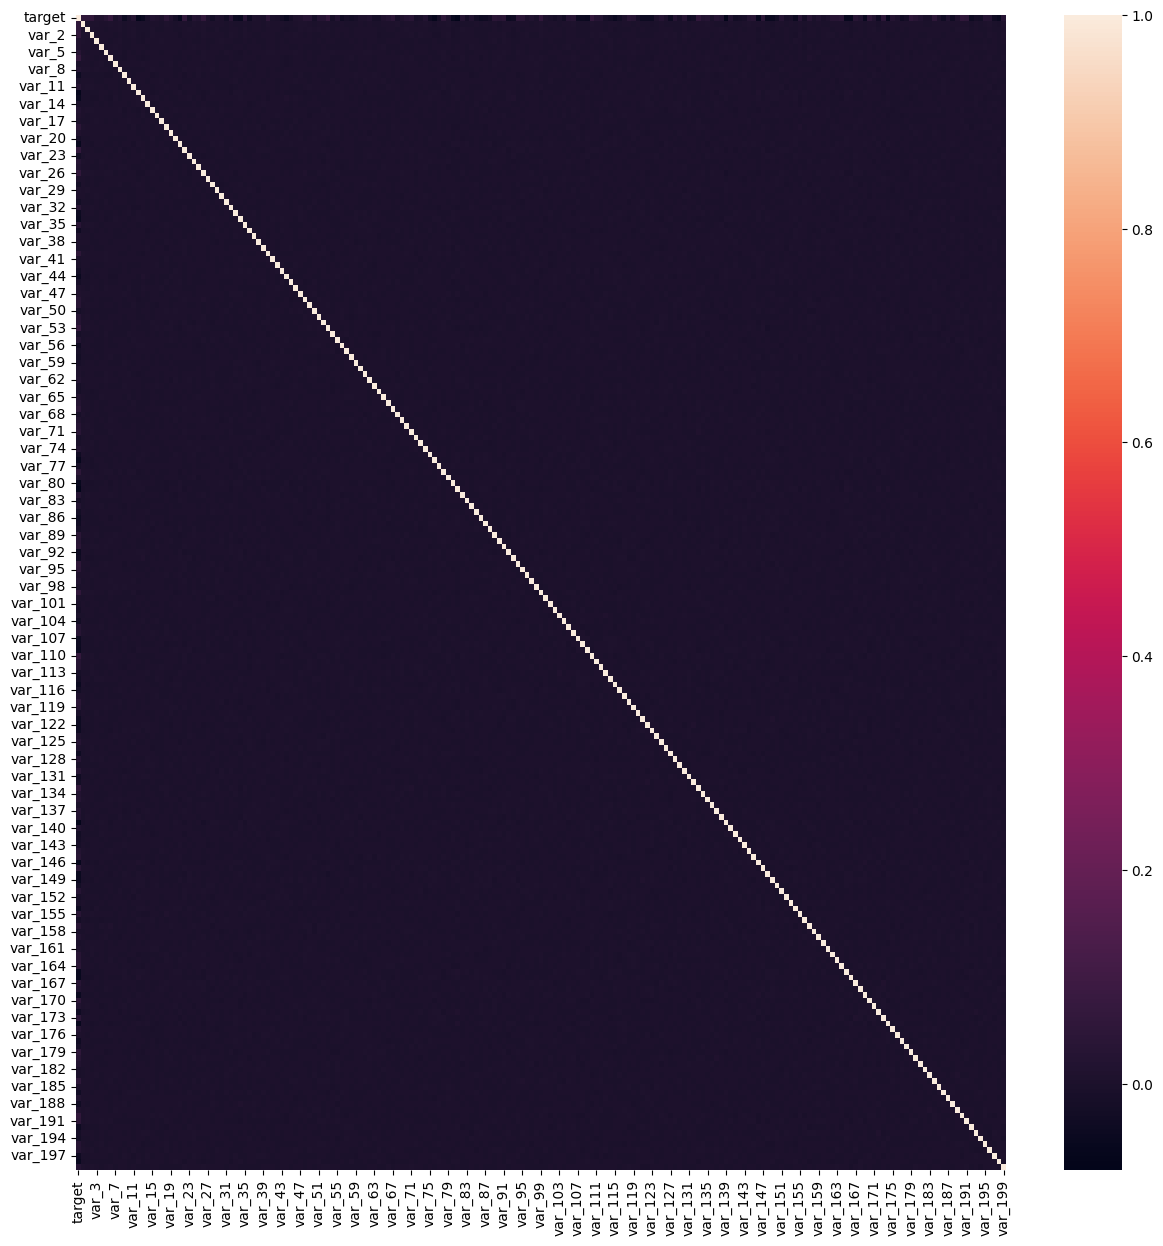

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df.corr())

*Feature Distributions*

In [5]:
def plot_feature_distribution(df):
    plt.title("Distribution of all features")
    fig, axes = plt.subplots(20, 10, figsize=(20, 50))
    fig.subplots_adjust(hspace=1.01, wspace=0.1)

    for i, col in enumerate(df.columns[1:]):
        plt.subplot(20,10,i+1)
        sns.histplot(data=df, x=col, kde=True, hue='target')
        plt.tick_params(axis='both', left=False, bottom=False, labelleft=False)
        plt.ylabel('')

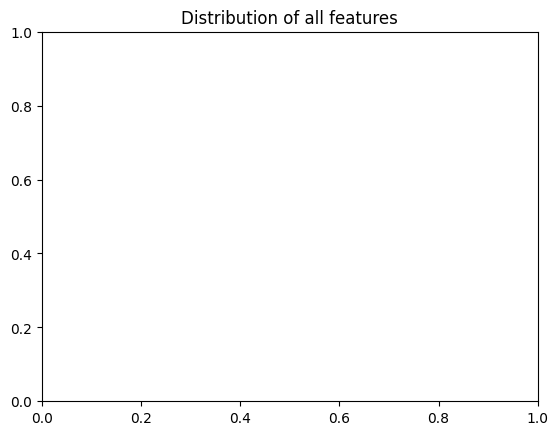

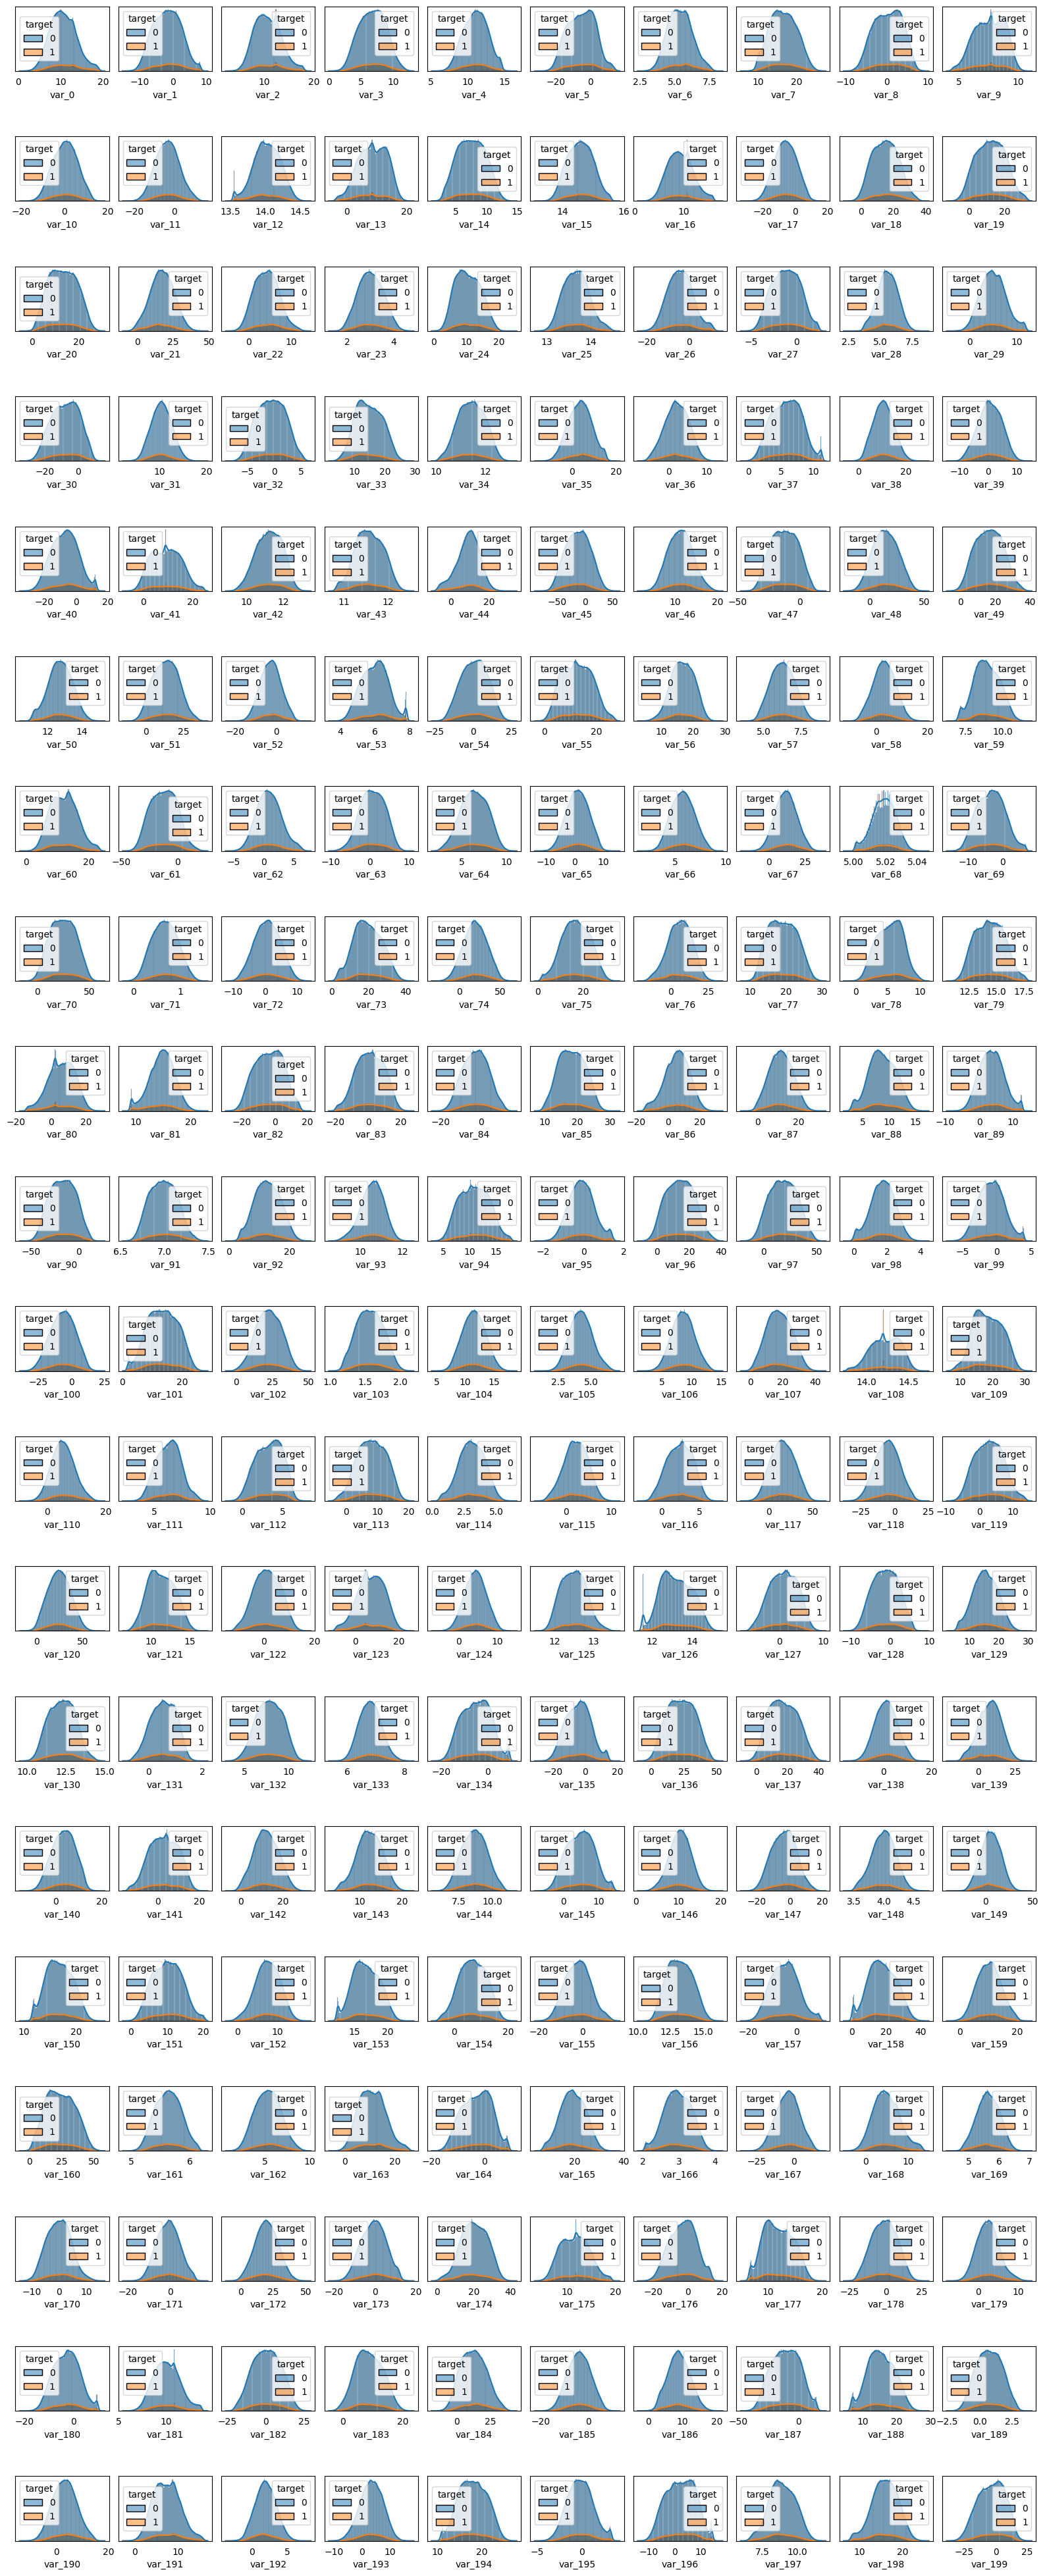

In [6]:
plot_feature_distribution(train_df)

*Balance of target variable*

<Axes: xlabel='target', ylabel='count'>

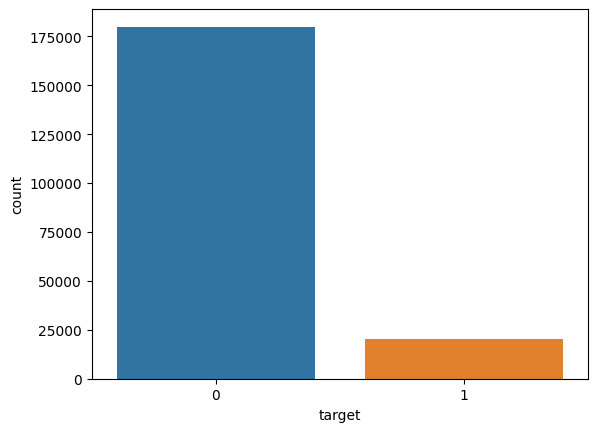

In [12]:
sns.countplot(data=train_df, x='target')

<Axes: ylabel='Density'>

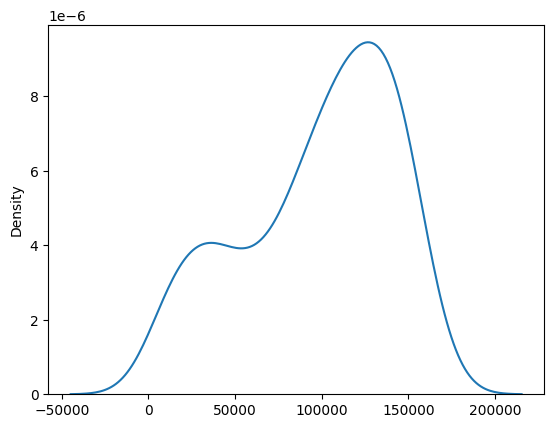

In [9]:
unique_per_feat = []
for i in train_df.iloc[:, 1:].columns:
    unique_per_feat.append(train_df[i].nunique())

sns.kdeplot(unique_per_feat)

**EDA Results**
1. All predictors are uncorrelated
2. All predictors seem to be normally distributed
3. Target variable is imbalanced

## Modeling

##### **Blending Algorithm**
Blending is an ensemble technique, it uses multiple machine learning algorithms for training on the same dataset. Here, unlike other ensemble techniques, there are two layers of machine-learning algorithms that are used, the first layer are base models and the second layer algorithms are known as meta models.

*How it works*
- The base models are trained on the training dataset provided first
- Once the base models are trained on the dataset, the test set is fed to the base models for prediction.
    - The predicted values from the base models are used for the training of the meta-model.
- The meta-models are trained on the prediction data
- After training, the meta-model assigns the weights to the base models and the output from the meta-models is considered the final output.

*Example*
let’s suppose we have 3 machine learning algorithms as base models and 1 algorithm as the meta model
1. The 3 base model are trained on the same dataset
2. The validation data is fed to all three base models and all three base models will predict different values for the same test data
3. The predictions from all the individual base models are used for training the meta-model
4. The output from the meta-models will be served as the final output

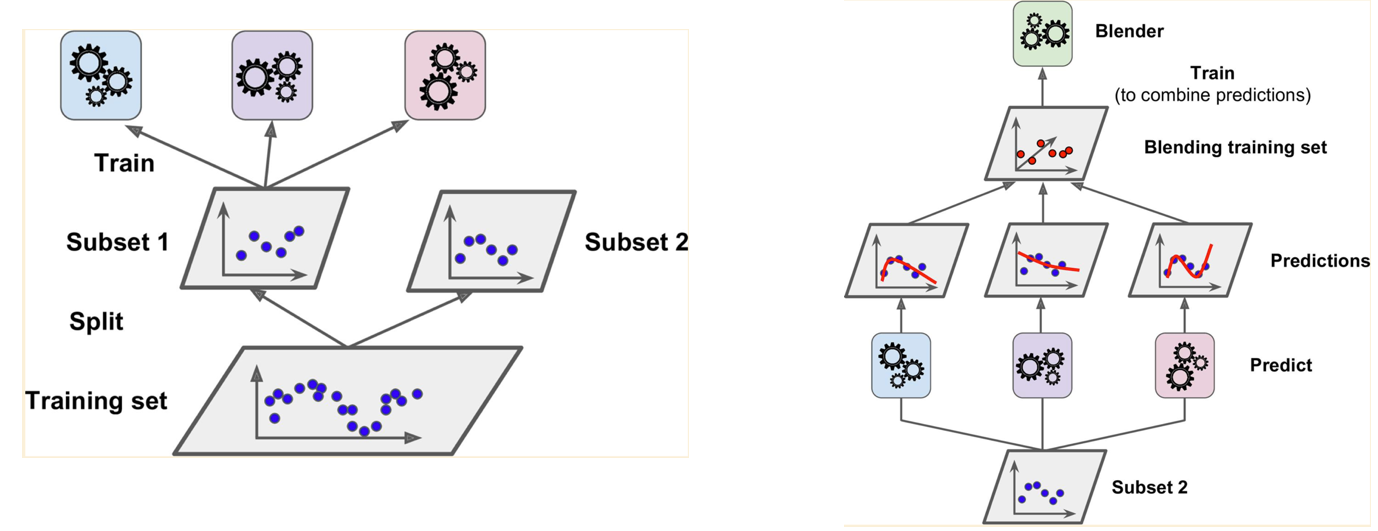

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lgbm', LGBMClassifier()),
    ('nn', MLPClassifier())]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X, y)

c:\Users\Josh Ellis\projects\2023\santander-customer-transaction-prediction\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

class BlendClassifier:
    def __init__(self, blend_val_size=0.25, *args):
        self.blend_val_size=blend_val_size
        self.models = []
        model_idx = 1
        for model in args:
            self.models.append((f'model_{str(model_idx)}', model))
            model_idx += 1
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.blend_val_size, stratify=True, random_state=42)
        
        meta_X = []
        for name, model in self.models:
            # fit in training set
            model.fit(X_train, y_train)
            # predict on hold out set
            yhat = model.predict(X_test)
            # reshape predictions into a matrix with one column
            yhat = yhat.reshape(len(yhat), 1)
            # store predictions as input for blending
            meta_X.append(yhat)
        # create 2d array from predictions, each set is an input feature
        meta_X = np.hstack(meta_X)
        # define blending model
        blender = LogisticRegression()
        # fit on predictions from base models
        blender.fit(meta_X, y_val)
        return blender

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

def get_models():
    models = list()
    models.append(('lgbm', LGBMClassifier()))
    models.append(('nn', MLPClassifier()))
    return models


def fit_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        yhat = model.predict(X_val)
        # reshape predictions into a matrix with one column
        yhat = yhat.reshape(len(yhat), 1)
        # store predictions as input for blending
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # define blending model
    blender = LogisticRegression()
    # fit on predictions from base models
    blender.fit(meta_X, y_val)
    return blender


def predict_ensemble(models, blender, X_test):
    # make predictions with base models
    meta_X = list()
    for name, model in models:
        # predict with base model
        yhat = model.predict(X_test)

        yhat = yhat.reshape(len(yhat), 1)
        # store prediction
        meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
    meta_X = np.hstack(meta_X)
    # predict
    return blender.predict_proba(meta_X)[:, 1]

## New Section
---

In [16]:
df_train = pd.read_csv('data/input/train.csv')
df_test = pd.read_csv('data/input/test.csv')
raw_features = [c for c in df_train.columns if c not in ['ID_code', 'target']]

len_train = len(df_train)

In [17]:
test_values = df_test[raw_features].values
unique_samples = []

# Creates a matrix of 0s in the shape of the test data
unique_count = np.zeros_like(test_values)

for feature in tqdm(range(test_values.shape[1])):
    value_, index_, count_ = np.unique(test_values[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

# Create test frame with only real test data
real_test = df_test.iloc[real_samples_indexes]

100%|██████████| 200/200 [00:04<00:00, 40.91it/s]


In [18]:
# Combine the training and testing data into one dataframe
full_df = pd.concat([df_train, real_test])

# Create a value counts feature for each raw feature (+200 new features)
for feature in tqdm(raw_features):
    val_counts = full_df[feature].value_counts().to_dict()
    df_train[f'{feature}_counts'] = df_train[feature].map(val_counts)
    df_test[f'{feature}_counts'] = df_test[feature].map(val_counts)

100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


In [19]:
train = pd.concat([df_train, df_test]).reset_index(drop = True)

In [20]:
for f in tqdm(raw_features):
    mean_dist = np.abs(train[f] - full_df[f].mean())
    max_dist = np.abs(train[f] - full_df[f].max())
    min_dist = np.abs(train[f] - full_df[f].min())
    median_dist = np.abs(train[f] - full_df[f].median())
    mode_dist = np.abs(train[f] - full_df[f].mode())
    train['{}_mean_ratio'.format(f)] = np.log(train['{}_counts'.format(f)]) / mean_dist
    train['{}_max_ratio'.format(f)] = np.log(train['{}_counts'.format(f)]) / max_dist
    train['{}_min_ratio'.format(f)] = np.log(train['{}_counts'.format(f)]) / min_dist
    train['{}_median_ratio'.format(f)] = np.log(train['{}_counts'.format(f)]) / median_dist

100%|██████████| 200/200 [00:17<00:00, 11.73it/s]


In [10]:
for f in tqdm(raw_features):
    train['{}_counts'.format(f)] = minmax_scale(train['{}_counts'.format(f)])

100%|██████████| 200/200 [00:01<00:00, 168.92it/s]


In [21]:
test = train[len_train:].drop(columns=['ID_code', 'target'])
train = train[:len_train].drop(columns=['ID_code'])

In [22]:
del  max_dist, mean_dist, median_dist, mode_dist, real_test, unique_count

---

In [2]:
train_cleaned = pd.read_parquet('data/processed/train_processed.parquet').iloc[:, :401]
test_cleaned = pd.read_parquet('data/processed/test_processed.parquet').iloc[:, :400]

# X_train, X_valid, y_train, y_valid = train_test_split(train_cleaned.drop(columns='target'), train_cleaned['target'], test_size=0.30)

In [15]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [1000, 2000, 3000]
}

clf = MLPClassifier()
search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=3, scoring='roc_auc').fit(train_cleaned.drop(columns='target'), train_cleaned['target'])

# Print the best hyperparameters and score
print("Best parameters: ", search.best_params_)
print("Best score: ", search.best_score_)

In [ ]:
pd.DataFrame(search.cv_results_).to_csv('hyperparameter_results/mlpclassifier.csv', index=False)

In [14]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler

X_train, X_valid, y_train, y_valid = train_test_split(train_cleaned.drop(columns='target'), train_cleaned['target'], test_size=0.30)

# Scale Predictors
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

estimators = [
    ('lgbm', LGBMClassifier(num_leaves=30, n_estimators=200, max_depth=5, learning_rate=0.1)),
    ('xgb', XGBClassifier(subsample=1, n_estimators=200, max_depth=3, learning_rate=0.2, gamma=0.1, colsample_bytree=1))
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)

yhat_valid = clf.predict_proba(X_valid)[:, 1:]
yhat_valid = [item for sublist in yhat_valid for item in sublist]

metrics.roc_auc_score(y_valid, yhat_valid)

0.8934071038179867

- Nothing = 87.617
- MinMax Scaler 87.778
- Stacking with:
    - Preprocessing: MinMaxScaler()
    - Base Models: lgbm and xgb (base models)
    - Meta Model: Logistic Regression (base Model)
    - Score = 88.4977
- Tuned XGBoost Score: 88.8697
- Stacking with:
    - Preprocessing: MinMaxScaler()
    - Base Models: lgbm and xgb (Tuned models)
    - Meta Model: Logistic Regression (base Model)
    - Score = 89.3407

#### **Full training and submission**

In [1]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

*Read training and test data*

In [2]:
train_cleaned = pd.read_parquet('data/processed/train_processed.parquet').iloc[:, :401]
test_cleaned = pd.read_parquet('data/processed/test_processed.parquet').iloc[:, :400]

*Train Classifier with Kaggle Training Data*

In [3]:
# Split X and y from training data
X_train = train_cleaned.drop(columns='target')  # 400 Predictors
y_train = train_cleaned['target']  # 1 Binary Response

# Scale Predictors
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Initialize Classifier -> Stacking Classifier
estimators = [
    ('lgbm', LGBMClassifier(num_leaves=30, n_estimators=200, max_depth=5, learning_rate=0.1)),
    ('xgb', XGBClassifier(subsample=1, n_estimators=200, max_depth=3, learning_rate=0.2, gamma=0.1, colsample_bytree=1))
]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Train classifier with full training data
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lgbm',
                                LGBMClassifier(max_depth=5, n_estimators=200,
                                               num_leaves=30)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0.1,
                                              gpu_id=None, grow_policy=...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.2, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=LogisticRegression())

*Make predictions with Kaggle Test Data*

In [4]:
# Scale Test data from scaler fitted on training data
X_test = scaler.fit_transform(test_cleaned)

# Make predictions with test data predictors
yhat = clf.predict_proba(X_test)[:, 1:]
yhat = [item for sublist in yhat for item in sublist]

*Save predictions for submission to Kaggle*

In [6]:
submission = pd.DataFrame({
    'ID_code': pd.read_csv('data/input/test.csv', usecols=['ID_code']).iloc[:, 0].to_list(),
    'target': yhat})

submission.to_csv('submissions/submission.csv', index=False)